The aim of this notebook is to serve as a repository of some kind of any and important information I can find on the concept of Transformers in the fild of ML/AI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# check if GPU is used
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f"Found GPU device at {device_name}")

Found GPU device at /device:GPU:0


2022-07-05 07:39:53.223752: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 07:39:53.305724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:39:53.431730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:39:53.433210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## What is the Transformer Architecture


![The Transformer](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)


After the revolution of the research paper from scientists at Google, [Attention is all you need](https://arxiv.org/abs/1706.03762), the field of Natural Language Processing exploded with the new architecture proposed, The Transformer. The Transformer is special because it dealt away with recurrence in its architecture and focused solely on attention mechanisms. 

RNNs, recurrent neural networks, were the start of the art ways of creating ML models in the field of Natural Language Processing. RNNs work well with tasks like sentiment analysis or topic modelling. In order to use RNNs for sequence-sequence tasks like translation, summarization or text generation, the model had to be designed in such a way that one section would be for the encoder (the goal of which is to create a rich representation of the text input) and the other section would be for the decoder (which would receive outputs from the encoder and use it to output tokens for the task at hand). The encoders and decoders are usually similarly designed with the decoder usually having some sort of mask so that future tokens are not seen (otherwise its predictions would be trivial). 

The problem with RNNs is that they're quite slow and can't really handle long sequences. Improvements to the RNNs is the use of attention mechanisms. With the paper from the Google scientists, the Transformer dealt away with recurrence altogether and used only attention mechanisms for its architecture. It uses self-attention to detect subtle ways even distant data elememts in a sequence influence and depend on each other. 

In other to understand how the transformer works, we need to carefully explain its different layers with its basic implentation as is done below.

Heavy inspiration - 

* https://www.tensorflow.org/text/tutorials/transformer

* https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/tensorflow/transformer.ipynb#scrollTo=s_qNSzzyaCbD

* https://colab.research.google.com/drive/1CBe2VlogbyXzmIyRQGH5xzuvLwGrvjcf?usp=sharing#scrollTo=y7TFAAnXklib

* https://sungwookyoo.github.io/study/Transformer/


## Data Input

We use the steps in the tutorial from the [official TensorFlow tutorial](https://www.tensorflow.org/text/tutorials/transformer) load the Portuguese-English translation dataset, tokenize and make it in batches

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

train_examples, valid_examples = examples['train'], examples['validation']

2022-07-05 07:39:56.464492: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-train.tfrecord...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-validation.tfrecord...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-test.tfrecord...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


2022-07-05 07:40:21.990825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:40:21.992210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:40:21.993637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:40:21.995216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 07:40:21.996478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [4]:
# let's see some of the entries in the dataset
for pt, en in train_examples.take(5):
    print("Portuguese: ", pt.numpy().decode('utf-8'))
    print("English: ", en.numpy().decode('utf-8'))
    print('\n')

2022-07-05 07:40:22.529888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Portuguese:  e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
English:  and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


Portuguese:  mas e se estes fatores fossem ativos ?
English:  but what if it were active ?


Portuguese:  mas eles não tinham a curiosidade de me testar .
English:  but they did n't test for curiosity .


Portuguese:  e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
English:  and this conscious defiance is why i , as an agnostic , can still have faith .


Portuguese:  `` `` '' podem usar tudo sobre a mesa no meu corpo . ''
English:  you can use everything on the table on me .




2022-07-05 07:40:22.586799: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Tokenization and detokenization

In [5]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples),
                                                                         target_vocab_size = 2**13)
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples),
                                                                        target_vocab_size = 2**13)

In [6]:
sample_text = 'Transformer is awesome'
tokenized_text = tokenizer_en.encode(sample_text)
tokenized_text

[7915, 1248, 7946, 7194, 13, 2799]

In [7]:
original_text = tokenizer_en.decode(tokenized_text)
original_text

'Transformer is awesome'

In [8]:
for ch in tokenized_text:
    print(f"{ch} --> {tokenizer_en.decode([ch])}")

7915 --> T
1248 --> ran
7946 --> s
7194 --> former 
13 --> is 
2799 --> awesome


The transformer needs special tokens to know the start and the end of each text. So here's a function to add it

In [9]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]

    return lang1, lang2

In [10]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    
    return result_pt, result_en

A simple input pipeline that processes, shuffles and batches the data:

In [11]:
MAX_LENGTH = 128
def filter_max_length(x, y, maxlen = MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= maxlen, tf.size(y) <= maxlen)

In [12]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [13]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = valid_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [14]:
# let's see if it works as intended
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

2022-07-05 07:44:13.337816: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(64, 74), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,   87, 3427, ...,    0,    0,    0],
        [8214,  291,   99, ...,    0,    0,    0],
        [8214,   95,    3, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 70), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   25,   24, ...,    0,    0,    0],
        [8087,   32, 1610, ...,    0,    0,    0],
        [8087,   17,   20, ...,    0,    0,    0]])>)

## Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 
​
The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.
​
The formula for calculating the positional encoding is as follows:
​
$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [15]:
def get_angles(pos, i, d_model):
    """Function to add positional encoding to the vector embeddings to be fed to the transformer
    Follows the formula given by the Transformer paper.
    
    d_model: refers to the dimension of the model used
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2))/np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                            np.arange(d_model)[np.newaxis,:], 
                            d_model)
    
    # apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [16]:
pos_encoding = positional_encoding(50, 512)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
          1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
        [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
          9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
        [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
          9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
        [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
          9.99986112e-01,  5.07947942e-03,  9.99987125e-01]]],
      dtype=float32)>

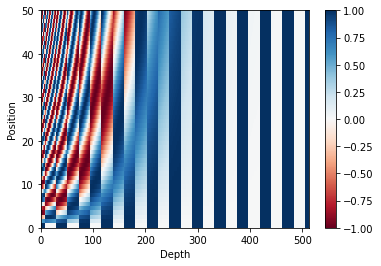

In [17]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise

In [18]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # add extra dimension to add padding to the attention logits
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [19]:
# let's test this out
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [20]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [21]:
def create_masks(inp, tar):
    # encoder padding mask (also necessary for 2nd attention block in the decoder)
    enc_padding_mask = create_padding_mask(inp)
        
    # dec padding mask - used in the 2nd attention block in the decoder
    dec_padding_mask = create_padding_mask(inp)
        
    # used in the first attention block
    # used to pad and mask future tokens in the tokens received by the decoder
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
    return enc_padding_mask, combined_mask, dec_padding_mask

## Attention

![](https://e2eml.school/images/transformers/architecture_single_head.png)

The primary concept to grasp about Transformers is the self-attention or intra attention mechanism. The self in self-attention refers to the fact that the attention weights are computed for all hidden states in the same set - for example, all the hidden states of the encoder. As the transformer model processes each word, self-attention allows it to look at other positions in the input sequences for clues that can help it lead to a better encoding for the particular word.

The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The main idea behind attention is that instead of producing a single hidden state for the input sequence, the encoder outputs a hidden state at each step that the decoder can access. However, using all the states at the same time would create a huge input for the decoder. This is where attention comes in - it lets the decoder assign a different amount of weight or attention to each of the encoder states at every decoding timestep.

Steps:

a. Create three vectors from each of the encoder's input vectors(embeddings of each word). The dimension of the input embeddings is given as d_model in the paper and they used an embedding size of 512. For each attention unit the transformer model learns three weight matrices; the query weights, the key weights, and the value weights. For each token, the input word embedding is multiplied with each of the three weight matrices to produce a query vector Q((vector representation of one word in the sequence), a key vector K (vector representations of all the words in the sequence), and a value vector V(which are the vector representations of all the words in the sequence).

The query Q represents the feature of interest and the matrix K represents the collection of masks. Because it's stored with masks in columns, rather than rows, it needs to be transposed (with the T operator) before multiplying. The vectors q, k, v are smaller in dimension than the embedding vector. The reason for this will be explained soon.

b. Calculate a score: The attention score is calculated by taking the dot product of the query vector and the key vector of the respective word we're scoring. For a sequence of n inputs, we'd have a corresponding n x n matrix of attention scores.

c. Scaling: The attention scores are divided by √dk (dimension of the key vector or depth). This dimension is equal to 64 in the paper, so the matrix of attention scores is scaled by 1/8. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. So the square root of dk is used for scaling, so you get a consistent variance regardless of the value of dk. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn

d. Normalized: The attention scores in the matrix are normalized so that they add up to 1. This is done with the softmax function. The matrix obtained after this step is known as the attention weights.

e. Multiply the value vector V for each word by the attention weights and then sum up to produce the output of the self-attention lyer for that position. It is probably helpful to think of the attention weights as where to look and the Value vector as what one wants to actually get. 

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    """calculate the attention weights. 
    q - query vectors; shape == (..., seq_len_q, depth)
    k: key;            shape == (..., seq_len_k, depth)
    v: value;          shape == (..., seq_len_v, depth_v)
   
    The process in the encoder is called self-attention because these three vectors are from the same source
    The q, k, v must have the same dimensions - d_q, d_k, d_v respectively. In this implementation, they'll be set to 64
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)
    
    # add mask
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # normalize the scaled_attention_logits with softmax so they add up to 1
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [23]:
# let's see if this works as intended

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('\nOutput is:')
    print(temp_out)

In [24]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)
                     
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)

Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Multi-head attention consists of these parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.


The self-attention is refined by carrying it out across several heads. In the paper, they carried out the self-attention step across 8 head. This is known as Multi-Head Attention. Each attention head( (an instance of attention computation) computes its own attention.

So far according to the paper, we have d_model = 512 (dimension of the embeddings), d_k = 64 (dimension of the key and query vectors), and h = 8 (number of attention heads). The paper also used d_v (dimension of the value vector) to be 64 just like the key and query vectors, however this doesn't have to be so.

####  Why is Multi-Head Attention Needed?

Looking at the attention formula given above, we see that the softmax functions which outputs probabilities forces the attention calculation in the range (0, 1) and it helps to emphasize the highest value, while agressively squashing the smallest. The problem with this is that it allows attention to focus on a single element (the one with the highest probability) and leave out the rest which still have a lot of information in them. Sometimes it's useful to keep several of the preceding words in mind when predicting the next, and the softmax just robbed us of that. This is a problem for the model.

The solution to this problem is to have several instances of attention or heads running at once. This lets the the transformer consider several previous words simultaneously when predicting the next. Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. It brings back the power we had before we pulled the softmax into the picture. 

The intuition behind multi-head attention is that it allows us to attend to different parts of the sequence differently each time. This practically means that:

a. The model can better capture positional information because each head will attend to different segments of the input. The combination of them will give us a more robust representation.

b. Each head will capture different contextual information as well, by correlating words in a unique manner.

However, computing many attention heads require a lot of computation. For the attention step to scale well, the query, key and value vectors are projected into lower-dimensional embedding space. This shrinks the matrices involved and dramatically reduces the computation time.

#### Next step:

However, the next step in the transformer architecture is not receiving matrices from *h* attention heads (8 in the paper). It is expecting a single matrix for each word. So, the multi-head attention matrices would need to be condensed:

a. Concatenate all attention matrices into one giant matrix.

b. Multiply the result of a above by Wo (weight matrix) that was trained jointly with the model.

This is shown below:

![](https://e2eml.school/images/transformers/multihead_attention_equation.png)

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model//self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def get_config(self):
        """Implement serialization so we can save the model"""
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
        })
        return config
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention) #(batch_size, seq_len_q, d_model)
        
        return output, attention_weights

In [26]:
# let's check if this works as intended
temp_multihead = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))
out, attn = temp_multihead(y, k=y, q=y, mask=None)

In [27]:
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Pointwise Feed-Forward Network

The FFN layer in the encoder and decoder is just a simple two-layer fully-connected network which processes each embeddings independently. A rule of thumb from the paper is that the hidden units of the first layer to be 4x the size of the embeddings. That is, dff = 4 x d_model. 
The FFN is labeled as Linear in the transformer architecture diagram above.

In [28]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [29]:
sample_ffn = point_wise_feed_forward_network(512, 30)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## The Encoder Layer

Each encoder layer consists of:

a. Multi-Head Attention layer

b. Feed Forward layer

The encoder layers also include layer normalization and skip connections. This is represented by the Add & Norm section of the transformer architecture diagram above. 

#### Skip Connections
Skip connections occur around the Multi-Head attention blocks and around the element-wise feed forward blocks. Skip connections give a transformer a tiny ability to allow the representations of different levels of processing to interact.

In skip connections, a copy of the input is added to the output of a set of calculations. This is seen in the code block below as the output of the multi-head attention is added to the vector k, q, v again - the inputs to the attention block are added back to its output. Also, the input to the element-wise feed forward network are added to its outputs. 

This serves two purposes:
a. It helps keep the gradient smooth which is a big help for backpropagtion: Attention is a filter, which means that when it is working correctly, it will block most of what tries to pass through it. The result of this is small changes in a lot of the inputs may not produce much change in the output if they happen to fall into the channels that are blocked. This produces dead spots in the gradients where it is flat. Skip connections help to smooth these out.

b. It helps to preserve the original input sequence: Even with lots of attention heads, there's no guarantee a word will attend to its own position. It's possible for the attention filter to forget entirely about the most recent word in favour of watching all of the earlier words that might be relevant. A skip connection takes the original word and manually adds it back into the signal so that there's no way it can be dropped or forgotten.

Thanks to skip connections, successive layers don't provide increasingly sophisticated abstractions as much as they provide redundancy. Whatever opportunities for focusing attention and creating useful features and making accurate predictions were missed in one layer can always be caught by the next.

#### Layer Normalization

The values of the matrix are shifted to have a mean of zero and scaled to have a standard deviation of one.

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.multihead = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.multihead(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

In [31]:
# test
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, mask=None)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

## The Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

I'll skip the explanation of differences until we stack up the decoder layers later below

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.multihead1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.multihead2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.multihead1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # becomes the query vector in the next step
        
        attn2, attn_weights_block2 = self.multihead2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [33]:
# let's test this out
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(x=tf.random.uniform((64, 50, 512)), enc_output=sample_encoder_layer_output, 
                                                        training=False, look_ahead_mask=None, padding_mask=None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

## The Encoder

The Encoder class implemented below consists of the following layers:

a. Embedding layer

b. Positional Encoding

c. Stacks of the encoder sublayers

#### Embedding

Word embeddings are a representation of a symbol (word, character, sentence) in a distributed low-dimensional space of continuous-valued vectors. Word embeddings map human language into a structured geometric space. As opposed to one-hot encodings, word embeddings consist of floating-point vectors (that is, dense vectors as opposed to sparse vectors). It’s common to seeword embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional unlike the one-hot encoding paradign with thousands of dimensions. This means that embeddings packs more information into far fewer dimensions (high embedding dimensions is more information retained).

A good embedding groups words with similar meanings together. A model that works with an embedding learns patterns in the embedded space. That means that whatever it learns to do with one word automatically gets applied to all the words right next to it. This has the added benefit of reducing the amount of training data needed. Each example gives a little bit of learning that gets applied across a whole neighborhood of words. The embeddings is done below with the tf.keras,Embedding(sequence_length, embedding_dimensionality). The dimension for embedding (from the paper) is d_model = 512.

#### Positional Encoding

As explained in the section above, position information need to be added to the word embeddings. As it's an addition operation, it doesn't alter the shape of the embeddings vector. 

#### Stack of Encoder sublayers

Asides the embeddings and positional encoding, the rest of the encoder consists of multi-head attention block and the element-wise feed forward network. Each encoder sublayer passes its output to the next encoder layer until the end which is then passed on to the decoder for the decoding to begin. The number of encoding sublayers can also be controlled by the num_layers argument (6 layers was used in the paper) in the code below

In [34]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model=self.d_model, num_heads=num_heads, dff=dff, rate=rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def get_config(self):
        """Initialize serialization so we can save model"""
        config = super().get_config()
        config.update({
            "num_layers": num_layers,
            "d_model": d_model,"num_heads": num_heads,
            "dff": dff, "input_vocab_size": input_vocab_size,
            "maximum_position_encoding": MAX_LENGTH,
            "rate": dropout_rate
        })
        return config
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # add embedding and position encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # tf.math.sqrt doesn't support int types
        x += self.pos_encoding[:, :tf.shape(x)[1], :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [35]:
# let's test this
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## The Decoder

Just like the Encoder, the Decoder also consists of the:

a. Embedding

b. Positional encoding

c. Stacks of decoding layers.

The output of the decoder is passed on to the final layer which is followed by a softmax layer so it outputs the probabilities of a particular word for every step.

A major difference between the Encoder and the Decoder is that the decoder has two attention sublayers

a. Masked multi-head attention layer: ensures that the tokens we generate at each timestep are only based on the past outputs and current tokens being predicted. To achieve this, we mask the next word embeddings (by setting them to −inf)

b. Encoder - decoder attention layer:This is actually where the decoder processes the encoded representation. The attention matrix generated by the encoder is passed to another attention layer alongside the result of the previous Masked Multi-head attention block.

This performs multihead attention over the output key and value vectors of the encoder stack with the intermediate representations of the decoder acting as the queries. The output of the top encoder is transformed into a set of attention vectors K and V. These are to be used by each decoder in its encoder-decoder attention layer. These are to be used by each decoder focus on appropriate places in the input sequence.

The results of the decoder inputs are embedded with positional encoding to indicate the position of each word. 
The self-attention layer in the decoder is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions.

In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    
    def get_config(self):
        """Initialize serialization so we can save model"""
        config = super().get_config()
        config.update({
            "num_layers": num_layers,
            "d_model": d_model,"num_heads": num_heads,
            "dff": dff, "target_vocab_size": target_vocab_size,
            "maximum_position_encoding": MAX_LENGTH,
            "rate": dropout_rate
        })
        return config
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2
        
        return x, attention_weights

In [37]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## The Transformer

![](https://miro.medium.com/max/700/1*BHzGVskWGS_3jEcYYi6miQ.png)

Let's offer a high-level explanation of the transformer architecture here:

a. The Transformer consists of two arms - the Encoder and Decoder. The Encoder generates a rich vector representation of the input while the decoder predicts the next token based on the tokens it's being fed. The transformer architecture can be used for sequence-sequence tasks like translation.

b. The input to the Encoder is the word vectors obtained after tokenizing and padding the sequences from the text input. The STARTOFSEQUENCE and ENDOFSEQUENCE tokens needs to be added at the start and end of each text input. 

c. A dense vector embeddings of the input text is created. Positional encodings are added to the embeddings and this is fed to several attention heads. Layer normalization and skip connections are involved with this process so as to ensure smooth gradients for backpropagation.

d. The Encoder has N encoder sublayers and the output of one is passed to the next and the output at the top encoder is passed to the decoder.

e. The decoder has almost the exact architecture as the decoder but it computes a second type of attention - ensuring that future predictions only take the current and past tokens into considerations. This is done via masking as implemented in the previous section.

f. The output of the top decoder is passed through a final Dense layer and a softmax layer to output probabilities at each position step. At each step of prediction, the decoder uses only the current and past tokens, and the token with the highest probability at that stage is the output which is further being decoded to have it in text.

## Training Using Keras Functional API

### Hyperparameters and optimizer

In [38]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

In [39]:
# learning rate
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
    #def get_config(self):
        #config = super().get_config()
        #return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}
        
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
   

In [40]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

Text(0.5, 0, 'Train Step')

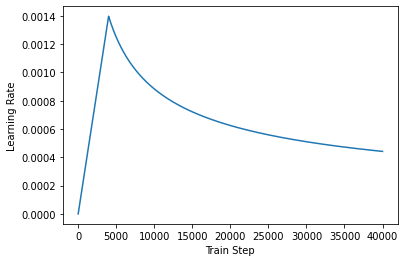

In [41]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Loss and Metrics

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [43]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [44]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [45]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

metrics = [masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

### Model Training

In [46]:
def build_model(input, target, num_layers = num_layers, d_model = d_model, num_heads = num_heads, 
               dff=dff, input_vocab_size = input_vocab_size, MAX_TOKENS = MAX_LENGTH, dropout_rate=dropout_rate):
    """Builds the model using Keras' Functional API"""
    
    # initiate the encoder and decoder layers
    encoder = Encoder(num_layers = num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=input_vocab_size, 
                      maximum_position_encoding=MAX_TOKENS, rate=dropout_rate)
    decoder = Decoder(num_layers = num_layers, d_model=d_model, num_heads=num_heads, dff=dff, target_vocab_size=target_vocab_size, 
                      maximum_position_encoding = MAX_TOKENS, rate=dropout_rate)
    
    # create the masks
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, target)
    
    # ops
    enc_output = encoder(input, training=True, mask=enc_padding_mask)
    dec_output, attention_weights = decoder(target, enc_output, True, combined_mask, dec_padding_mask)
    
    final_output = tf.keras.layers.Dense(target_vocab_size)(dec_output)
    model = tf.keras.models.Model(inputs=[input, target], outputs=final_output)
    
    return model

In [47]:
# define the input and target
input = tf.keras.layers.Input(shape=(None,))
target = tf.keras.layers.Input(shape=(None,))

model = build_model(input, target)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli ()                   0           tf.compat.v1.shape[0][0]         
______________________________________________________________________________________________

In [48]:
model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [49]:
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
    num_batches = batch
print(num_batches)

valid_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
    valid_batches = batch
print(valid_batches)

2022-07-05 07:44:30.841261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 7240 of 20000
2022-07-05 07:44:40.841463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 13997 of 20000
2022-07-05 07:44:49.241106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


807
18


In [50]:
def generator(dataset):
    while True:
        for pt_batch, en_batch in dataset:
            yield ([pt_batch , en_batch[:, :-1]], en_batch[:, 1:])

In [51]:
history = model.fit(x = generator(train_dataset), validation_data = generator(val_dataset), epochs=20, steps_per_epoch = num_batches, validation_steps = valid_batches)

Epoch 1/20
807/807 [==============================] - 116s 126ms/step - loss: 4.0141 - masked_loss: 7.2438 - sparse_categorical_accuracy: 0.6999 - val_loss: 1.6098 - val_masked_loss: 5.7120 - val_sparse_categorical_accuracy: 0.7710
Epoch 2/20
807/807 [==============================] - 98s 122ms/step - loss: 1.4613 - masked_loss: 5.1318 - sparse_categorical_accuracy: 0.7840 - val_loss: 1.3477 - val_masked_loss: 4.7933 - val_sparse_categorical_accuracy: 0.7976
Epoch 3/20
807/807 [==============================] - 98s 121ms/step - loss: 1.2982 - masked_loss: 4.5599 - sparse_categorical_accuracy: 0.8005 - val_loss: 1.2183 - val_masked_loss: 4.3312 - val_sparse_categorical_accuracy: 0.8105
Epoch 4/20
807/807 [==============================] - 97s 121ms/step - loss: 1.1489 - masked_loss: 4.0282 - sparse_categorical_accuracy: 0.8179 - val_loss: 1.0638 - val_masked_loss: 3.7797 - val_sparse_categorical_accuracy: 0.8315
Epoch 5/20
807/807 [==============================] - 98s 121ms/step - loss

In [52]:
for i in range(10):
    translation = [tokenizer_en.vocab_size]
    for _ in range(40):
        predict = model.predict([pt_batch[i:i+1],np.asarray([translation])])
        translation.append(np.argmax(predict[-1,-1]))
        if translation[-1] == tokenizer_en.vocab_size + 1:
            break
    
    real_translation = []
    for w in en_batch[:,1:][i].numpy():
        if w == tokenizer_en.vocab_size + 1:
            break
        real_translation.append(w)
    
    original_text = []
    for w in pt_batch[:, 1:][i].numpy():
        if w == tokenizer_pt.vocab_size + 1:
            break
        original_text.append(w)
    
    print(f"Original text: {tokenizer_pt.decode(original_text)}")
    print(f"Real translation: {tokenizer_en.decode(real_translation)}")
    print(f"Model Translation: {tokenizer_en.decode(translation[1:-1])}")
    print("")


Original text: tinham comido peixe com batatas fritas ?
Real translation: did they eat fish and chips ?
Model Translation: would you have eaten with the flew fries of fries ?

Original text: estava sempre preocupado em ser apanhado e enviado de volta .
Real translation: i was always worried about being caught and sent back .
Model Translation: i was always worried , worried about being caught .

Original text: escolhi um com o tom de pele de uma lagosta com um escaldão .
Real translation: i chose one with the skin color of a lobster when sunburnt .
Model Translation: i selected a tone of a anaakin to a stairs with an escape .

Original text: mas eu penso que isto é claramente falso .
Real translation: but i think this is quite clearly untrue .
Model Translation: but i think this is clearly faye .

Original text: temos medido o nosso progresso muito rigorosamente .
Real translation: we have measured our progress very rigorously .
Model Translation: we 've been measured our progress with

In [53]:
def translate(sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    inp_sentence = start_token + tokenizer_pt.encode(sentence) + end_token
    inp_sentence = tf.convert_to_tensor(np.array([inp_sentence]),dtype=tf.int64)
    
    translation = [tokenizer_en.vocab_size]# keeps track of tokens to feed to decoder at each time step
   
    for i in range(MAX_LENGTH):
        predictions = model.predict([inp_sentence, np.asarray([translation])])
        translation.append(np.argmax(predictions[-1,-1]))
        if translation[-1] == tokenizer_en.vocab_size + 1:
            break
    
    print(f"Original text: {sentence}")
    print(f"Model Translation: {tokenizer_en.decode(translation[1:-1])}")

In [54]:
sentence = 'e emitam certificados falsos'
translate(sentence)

Original text: e emitam certificados falsos
Model Translation: and they emitted the false papers of the fake place .


In [55]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Original text: este é um problema que temos que resolver.
Model Translation: this is a problem that we have to deal with two things that we have to solve .
Real translation: this is a problem we have to solve .


In [73]:
translate('eu te amo')
real_translation = 'I love you'
print(f"Real Translation: {real_translation}")

Original text: eu te amo
Model Translation: i love you , like , i love you .
Real Translation: I love you


In [71]:
translate('fazer sacrifícios virgens nos altares da ciência')
real_translation = 'make virgin sacrifices on the altars of science'
print(f"Real Translation: {real_translation}")

Original text: fazer sacrifícios virgens nos altares da ciência
Model Translation: to make virgins in the high science .
Real Translation: make virgin sacrifices on the altars of science


### Saving Model artifacts

In this part, we save everything that's needed to make inference with the transformer model in a simple python script

In [58]:
import pickle

# for english
with open('tokenizer_en.pickle', 'wb') as handle:
    pickle.dump(tokenizer_en, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
# for portuguese

# for english
with open('tokenizer_pt.pickle', 'wb') as handle:
    pickle.dump(tokenizer_pt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
# save the keras model
#model.save('./transformer_pt_english.h5')

In [61]:
model.save_weights("./transformer_pt_english.h5")